# Assignment5
# Nima Jahanbazfard

## Study Performance

### Imports

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.datasets import  fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing the data

In [40]:
data = pd.read_csv('study_performance.csv')
data

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data['race_ethnicity'] = le.fit_transform(data['race_ethnicity'])
data['parental_level_of_education'] = le.fit_transform(data['parental_level_of_education'])
data['lunch'] = le.fit_transform(data['lunch'])
data['test_preparation_course'] = le.fit_transform(data['test_preparation_course'])

In [42]:
data

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
...,...,...,...,...,...,...,...,...
995,0,4,3,1,0,88,99,95
996,1,2,2,0,1,62,55,55
997,0,2,2,0,0,59,71,65
998,0,3,4,1,0,68,78,77


In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler =  StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [50]:
y =data[:, -3:]
x =data[:, :5]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [56]:
X_train.shape

(800, 5)

In [57]:
y_train.shape

(800, 3)

In [58]:
toTensorTransform = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))

In [59]:
# Create a custom PyTorch dataset
class CaliforniaHousingDataset(Dataset):
    def __init__(self, features, targets, transform=None, target_transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y 

In [60]:
# Create instances of the custom dataset
train_dataset = CaliforniaHousingDataset(X_train, y_train, transform=toTensorTransform, 
                                         target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))

test_dataset = CaliforniaHousingDataset(X_test, y_test, transform=toTensorTransform, 
                                        target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [61]:
for data, target in train_loader:
    print(target.size())
    break

torch.Size([64, 1, 3])


### Building your model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [62]:
class MyLinear(nn.Module):

    def __init__(self, in_f, out_f, bias=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bias = bias
        self.w = nn.parameter.Parameter(torch.empty(out_f, in_f))
        if bias:
            self.b = nn.parameter.Parameter(torch.empty(out_f)) 
        self.reset_params()   ### initialization paramters
    
    def reset_params(self):
        nn.init.kaiming_normal_(self.w, nonlinearity="relu")
        if self.bias:
            nn.init.constant_(self.b, 0)

    def forward(self, x):
        return F.linear(x, self.w, self.b)

In [63]:
def build_model(input_size, hidden_size, output_size):
    model = nn.Sequential(nn.Linear(input_size, hidden_size), 
                           nn.ReLU(),
                           nn.Linear(hidden_size, hidden_size), 
                           nn.ReLU(),  
                           nn.Linear(hidden_size, output_size))
    return model

### Train & Test

In [70]:
num_epochs = 30

model = build_model(5, 100, 3)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [72]:
train_history = []
validation_history = []

for epoch in range(num_epochs):

    model.train()
    losses = []
    
    with tqdm(train_loader, leave=False) as bar:
        bar.set_description(f"[Epoch: {epoch + 1}/{num_epochs}]")
        
        for batch_idx, (data, target) in enumerate(bar):

            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            bar.set_postfix(avg_epoch_loss=f"{sum(losses)/len(losses):.4f}")
            train_history.append(sum(losses)/len(losses))
        
    model.eval()
    running_testloss = 0.0

    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):
            test_output = model(test_data)
            vloss = criterion(test_output, test_label)
            running_testloss += vloss.item()
        avg_vloss = running_testloss / (i + 1)
        validation_history.append(avg_vloss)
        if epoch % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}]: loss train: {sum(losses)/len(losses):.3f}, validation: {avg_vloss:.3f}')

[Epoch: 1/30]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/30]: loss train: 0.970, validation: 0.931


Epoch [20/30]: loss train: 0.992, validation: 0.932


Epoch [30/30]: loss train: 0.995, validation: 0.931


In [67]:
with torch.no_grad():
    for data, target in test_loader:
        y_pred = model(data[:10])
        print("y_true", target[:10])
        print("y_pred", y_pred)
        break

y_true tensor([[[ 1.6437,  1.1534,  1.0499]],

        [[-0.8636, -0.2172,  0.3257]],

        [[ 0.9179,  0.2625,  0.2598]],

        [[ 0.5220,  0.5366,  0.3257]],

        [[ 1.1818,  0.9478,  0.6549]],

        [[ 0.9839,  0.3996,  0.6549]],

        [[ 0.1921,  0.0569, -0.3328]],

        [[-0.7977, -0.5598, -0.3986]],

        [[ 1.3798,  0.2625,  0.2598]],

        [[-0.9956, -1.0395, -1.7813]]])
y_pred tensor([[0.0377, 0.0368, 0.0271],
        [0.0298, 0.0272, 0.0329],
        [0.0363, 0.0198, 0.0190],
        [0.0260, 0.0138, 0.0079],
        [0.0527, 0.0325, 0.0199],
        [0.0359, 0.0125, 0.0111],
        [0.0333, 0.0215, 0.0258],
        [0.0342, 0.0344, 0.0366],
        [0.0382, 0.0081, 0.0122],
        [0.0538, 0.0409, 0.0237]])


In [68]:
k = 4
num_val_samples = len(train_dataset) // k
num_epochs = 100

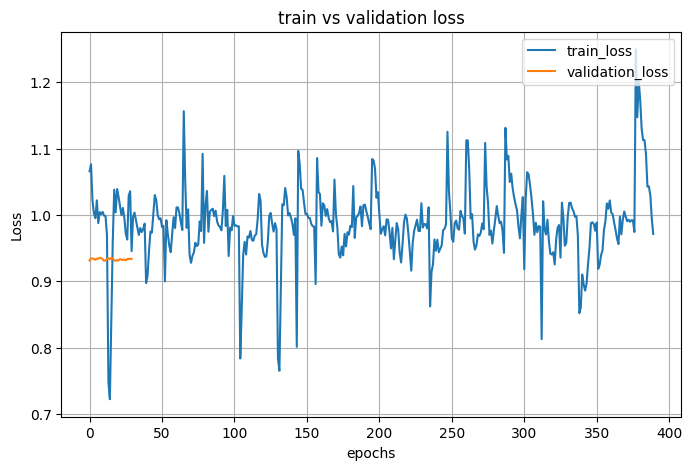

In [69]:


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_history, label="train_loss")
ax.plot(validation_history, label="validation_loss")
ax.set_title("train vs validation loss")
ax.set_ylabel('Loss')
ax.set_xlabel('epochs')
ax.grid()
ax.legend(loc='upper right')

## Obesity

### Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import sys
import shutil
assert sys.version_info >=(3,8), "This project requires Python 3.8+"
from packaging import version
import torch
assert version.parse(torch.__version__) >= version.parse("2.1.2"), "This project requires pytorch 2.1.1 or above!"
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data processing

In [4]:
data = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
data.info

<bound method DataFrame.info of             Age  Gender    Height      Weight        CALC FAVC  FCVC  NCP  \
0     21.000000  Female  1.620000   64.000000          no   no   2.0  3.0   
1     21.000000  Female  1.520000   56.000000   Sometimes   no   3.0  3.0   
2     23.000000    Male  1.800000   77.000000  Frequently   no   2.0  3.0   
3     27.000000    Male  1.800000   87.000000  Frequently   no   3.0  3.0   
4     22.000000    Male  1.780000   89.800000   Sometimes   no   2.0  1.0   
...         ...     ...       ...         ...         ...  ...   ...  ...   
2106  20.976842  Female  1.710730  131.408528   Sometimes  yes   3.0  3.0   
2107  21.982942  Female  1.748584  133.742943   Sometimes  yes   3.0  3.0   
2108  22.524036  Female  1.752206  133.689352   Sometimes  yes   3.0  3.0   
2109  24.361936  Female  1.739450  133.346641   Sometimes  yes   3.0  3.0   
2110  23.664709  Female  1.738836  133.472641   Sometimes  yes   3.0  3.0   

      SCC SMOKE      CH2O family_history_wi

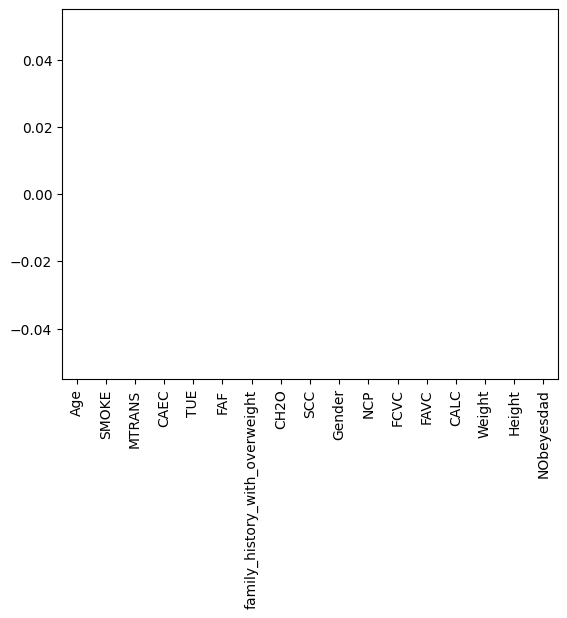

In [7]:
missing = data.isnull().sum()
missing = missing[missing >= 0]
missing = missing.sort_values(ascending=False)
missing.plot.bar(color='#a02933')
plt.show()

In [8]:
data

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,0.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
data['CALC'] = le.fit_transform(data['CALC'])
data['FAVC'] = le.fit_transform(data['FAVC'])
data['SCC'] = le.fit_transform(data['SCC'])
data['SMOKE'] = le.fit_transform(data['SMOKE'])
data['family_history_with_overweight'] = le.fit_transform(data['family_history_with_overweight'])
data['MTRANS'] = le.fit_transform(data['MTRANS'])
data['CAEC'] = le.fit_transform(data['CAEC'])
data['NObeyesdad'] = le.fit_transform(data['NObeyesdad'])

In [10]:
data

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,0,1.620000,64.000000,3,0,2.0,3.0,0,0,2.000000,1,0.000000,1.000000,2,3,1
1,21.000000,0,1.520000,56.000000,2,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,2,3,1
2,23.000000,1,1.800000,77.000000,1,0,2.0,3.0,0,0,2.000000,1,2.000000,1.000000,2,3,1
3,27.000000,1,1.800000,87.000000,1,0,3.0,3.0,0,0,2.000000,0,2.000000,0.000000,2,4,5
4,22.000000,1,1.780000,89.800000,2,0,2.0,1.0,0,0,2.000000,0,0.000000,0.000000,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,0,1.710730,131.408528,2,1,3.0,3.0,0,0,1.728139,1,1.676269,0.906247,2,3,4
2107,21.982942,0,1.748584,133.742943,2,1,3.0,3.0,0,0,2.005130,1,1.341390,0.599270,2,3,4
2108,22.524036,0,1.752206,133.689352,2,1,3.0,3.0,0,0,2.054193,1,1.414209,0.646288,2,3,4
2109,24.361936,0,1.739450,133.346641,2,1,3.0,3.0,0,0,2.852339,1,1.139107,0.586035,2,3,4


In [11]:
x=data.drop('NObeyesdad',axis=1)
y=data['NObeyesdad']

In [12]:
x.shape

(2111, 16)

In [13]:
y.shape

(2111,)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)

In [15]:
from torch.autograd import Variable

In [16]:
x_data_train = Variable(torch.from_numpy(X_train.values))
y_data_train = Variable(torch.from_numpy(np.array(y_train)))
x_data_test = Variable(torch.from_numpy(X_test.values))
y_data_test = Variable(torch.from_numpy(np.array(y_test)))

In [17]:
x_data_train.shape

torch.Size([1688, 16])

In [18]:
y_data_train.shape

torch.Size([1688])

In [19]:
class classifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super().__init__()
        self.name = 'Simple 3 Layer Classifier'
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.softmax(x)
        x = self.layer2(x)
        x = self.softmax(x)
        return x

In [20]:
simple_classifier = classifier(16, 512, 7).to(device=device)
simple_classifier

classifier(
  (layer1): Linear(in_features=16, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=7, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)

In [25]:
simple_classifier = classifier(16, 512, 7).to(device=device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(simple_classifier.parameters(), lr=0.001)
train_losses = []
test_losses = []

for epochs in range(10):
    simple_classifier.train()
    y_pred = simple_classifier(x_data_train.float())
    loss = criterion(y_pred, y_data_train.view(-1, 1).float())
    print(f'Epoch: {epochs} - Loss: {loss.item()}')
    train_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epochs%10 == 0:
        simple_classifier.eval()
        y_pred = simple_classifier(x_data_test.float())
        loss = criterion(y_pred, y_data_test.view(-1, 1).float())
        test_losses.append(loss.item())
        

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

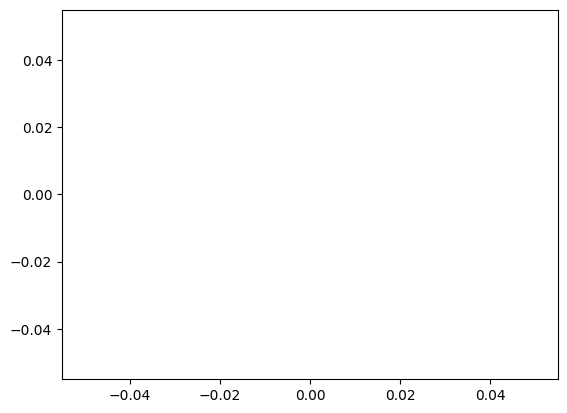

In [40]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.show()